# Putting it together: General Linear Models for Decoding

Full step-by-step example of fitting a GLM to perform a decoding experiment.
In this decoding analysis, we will be doing a one-vs-all classification.
We use the data from one subject of the Haxby dataset.

More specifically, we will:
* Download the Haxby dataset.
* Extract the information to generate a glm representing the blocks of stimuli.
* Analyze the decoding performance using a classifier.

In [1]:
import numpy as np
import pandas as pd

from nilearn.datasets import fetch_haxby

haxby_dataset = fetch_haxby(subjects=(3,))

# set TR in seconds, following information in the original paper
t_r = 2.5

[fetch_haxby] Dataset found in /Users/emdupre/nilearn_data/haxby2001


In [2]:
# Load target information as string 
behavior = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

unique_conditions = behavior["labels"].unique()
conditions = behavior["labels"].values

runs = behavior["chunks"].to_numpy()
unique_runs = behavior["chunks"].unique()

# events will take the form of a dictionary of Dataframes, one per run
events = {}

for run in unique_runs:

    # get the condition label per run
    conditions_run = conditions[runs == run]

    # get the number of scans per run, then the corresponding
    # vector of frame times
    n_scans = len(conditions_run)
    frame_times = t_r * np.arange(n_scans)

    # each event last the full TR
    duration = t_r * np.ones(n_scans)

    # Define the events object
    events_ = pd.DataFrame(
        {
            "onset": frame_times,
            "trial_type": conditions_run,
            "duration": duration,
        }
    )
    # remove the rest condition and insert into the dictionary
    # this will be our baseline in the GLM, so we don't want to model it as a condition
    events[run] = events_[events_.trial_type != "rest"]

In [3]:
from nilearn.image import index_img
from nilearn.glm.first_level import FirstLevelModel

# Instantiate the glm
glm = FirstLevelModel(
    t_r=t_r,
    mask_img=haxby_dataset.mask,
    high_pass=0.008,
    smoothing_fwhm=4,
)

z_maps = []
conditions_label = []
run_label = []

for run in unique_runs:
    # grab the fmri data for that particular run
    fmri_run = index_img(haxby_dataset.func[0], runs == run)

    # fit the GLM
    glm.fit(fmri_run, events=events[run])

    # set up contrasts: one per condition
    conditions = events[run].trial_type.unique()
    for condition_ in conditions:
        z_maps.append(glm.compute_contrast(condition_))
        conditions_label.append(condition_)
        run_label.append(run)

/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_18964/506106289.py:21: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm.fit(fmri_run, events=events[run])
/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_18964/506106289.py:21: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm.fit(fmri_run, events=events[run])
/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_18964/506106289.py:21: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  glm.fit(fmri_run, events=events[run])
/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_18964/506106289.py:21: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) whil

In [4]:
from sklearn.model_selection import LeaveOneGroupOut

from nilearn.decoding import Decoder

decoder = Decoder(
    estimator="svc",
    mask=haxby_dataset.mask,
    standardize=False,
    screening_percentile=5,
    cv=LeaveOneGroupOut(),
)
decoder.fit(z_maps, conditions_label, groups=run_label)

# Return the corresponding mean prediction accuracy compared to chance
# for classifying one-vs-all items.

classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
chance_level = 1.0 / len(np.unique(conditions))
print(
    f"Classification accuracy: {classification_accuracy:.4f} / "
    f"Chance level: {chance_level}"
)

Classification accuracy: 0.8423 / Chance level: 0.125


In [5]:
decoder.coef_img_

{'bottle': <nibabel.nifti1.Nifti1Image at 0x305db0ee0>,
 'cat': <nibabel.nifti1.Nifti1Image at 0x305dbe1c0>,
 'chair': <nibabel.nifti1.Nifti1Image at 0x305dbe130>,
 'face': <nibabel.nifti1.Nifti1Image at 0x305dbe5b0>,
 'house': <nibabel.nifti1.Nifti1Image at 0x305dbe490>,
 'scissors': <nibabel.nifti1.Nifti1Image at 0x305dbe670>,
 'scrambledpix': <nibabel.nifti1.Nifti1Image at 0x305dbedc0>,
 'shoe': <nibabel.nifti1.Nifti1Image at 0x305dbec10>}

/var/folders/_h/5_yjn8t51cs21zb_j5p6sqc00000gq/T/ipykernel_18964/1482435408.py:16: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf_stat_map(


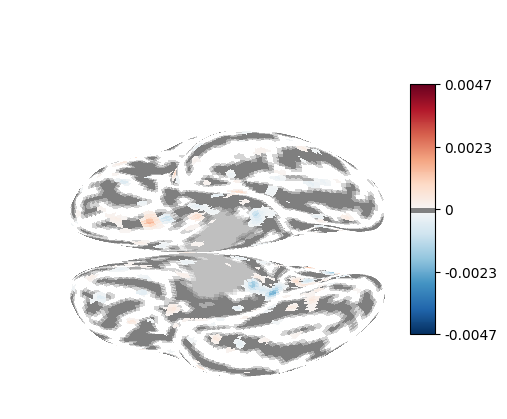

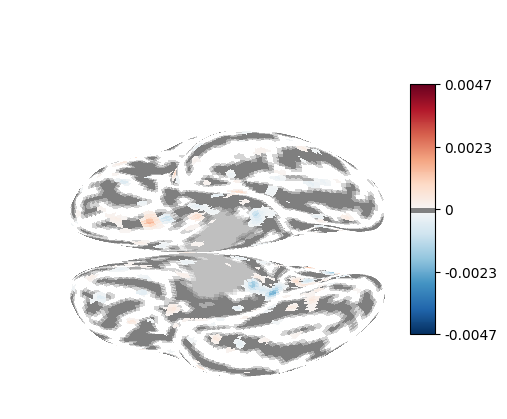

In [12]:
from nilearn.surface import SurfaceImage
from nilearn.plotting import plot_surf_stat_map
from nilearn.datasets import load_fsaverage, load_fsaverage_data

fsaverage_meshes = load_fsaverage()

surface_coef = SurfaceImage.from_volume(
    mesh=fsaverage_meshes["pial"],
    volume_img=decoder.coef_img_['face'],
)

curv_sign = load_fsaverage_data(data_type="curvature")
for hemi, data in curv_sign.data.parts.items():
    curv_sign.data.parts[hemi] = np.sign(data)

plot_surf_stat_map(
    surf_mesh=fsaverage_meshes["inflated"],
    stat_map=surface_coef,
    bg_map=curv_sign,
    hemi="both",
    view="ventral",
    threshold=0.0001,
    darkness=0.5,
)


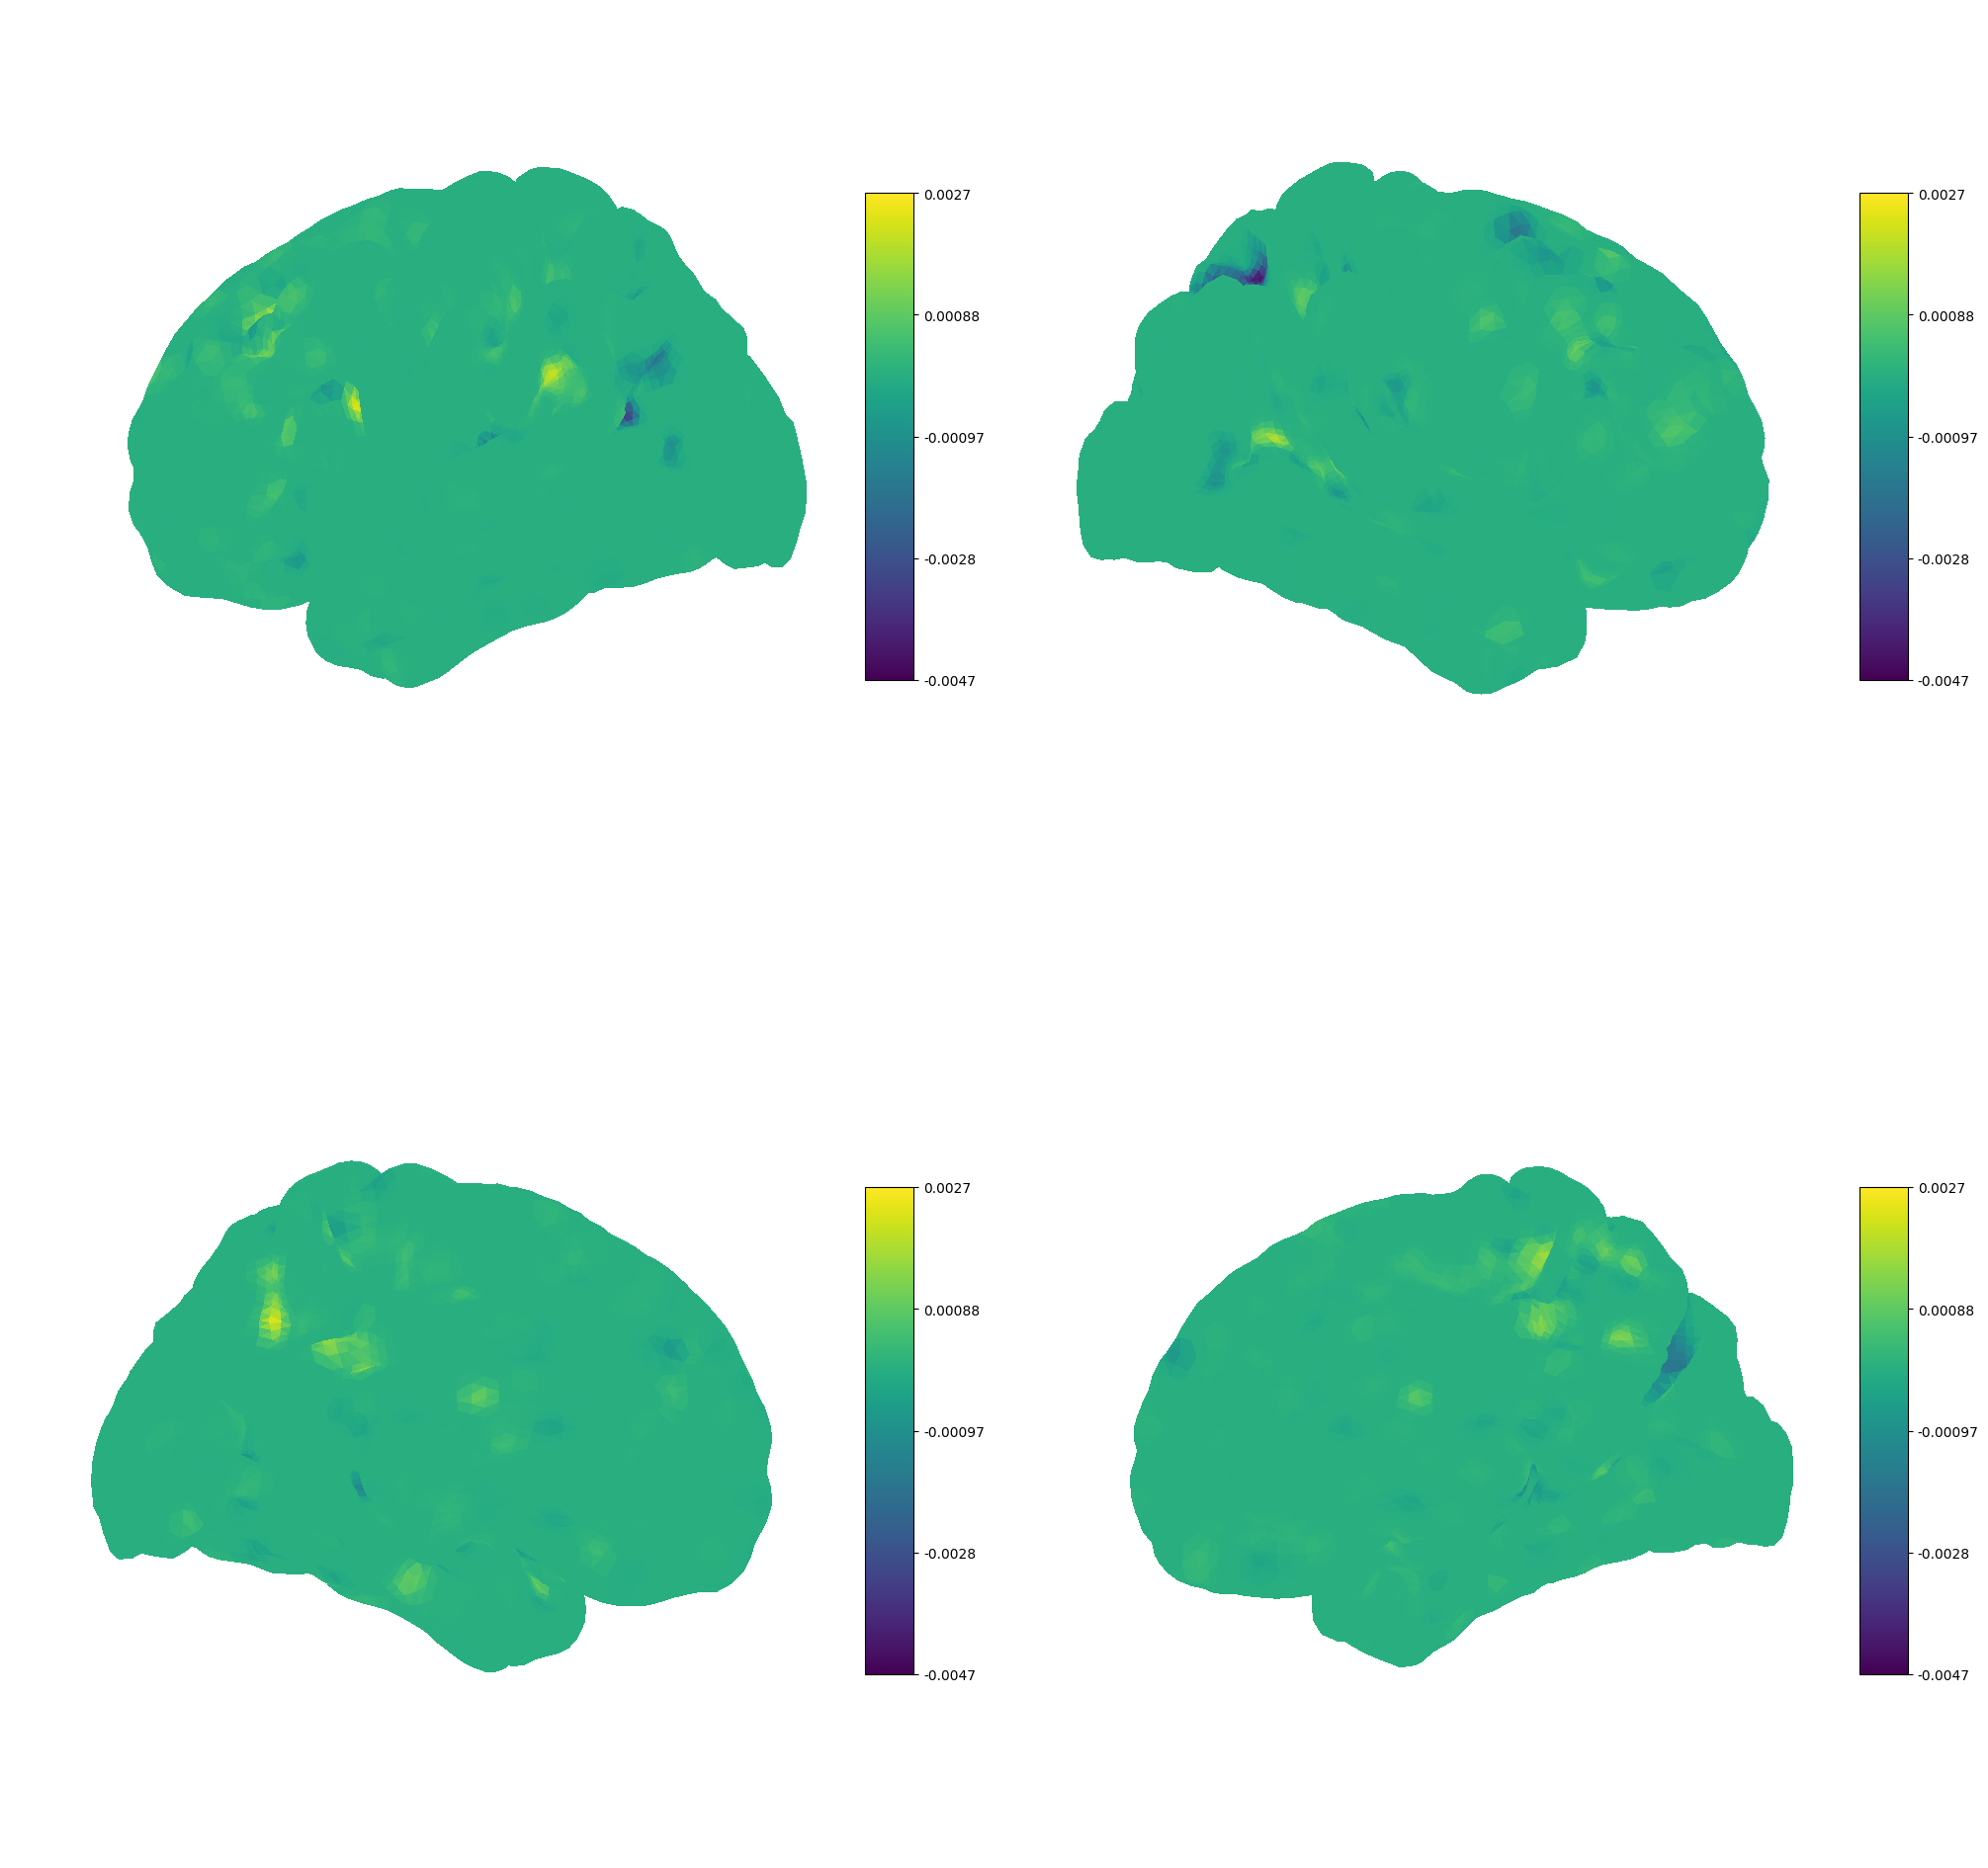

In [14]:
from nilearn.maskers import SurfaceMasker

surf_masker = SurfaceMasker(cmap="viridis").fit(surface_coef)
report = surf_masker.generate_report()
report